# Cleaning `COLOCACION` data

Imports:

In [4]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

from core_ds4a_project.cleaning import normalize_columns_name


pd.set_option("display.max_columns", None)

Environment variables:

In [5]:
load_dotenv('envvars')

ROOT_DATA_PATH = os.environ.get('ROOT_DATA_PATH')
RAW_DATA_PATH = os.environ.get('RAW_DATA_PATH') or f'{ROOT_DATA_PATH}/raw'
CLEAN_DATA_PATH = os.environ.get('CLEAN_DATA_PATH') or f'{ROOT_DATA_PATH}/clean'

Reading data:

In [6]:
file_name = 'FUNDACIaN AMANECER_RETO_COLOCACION 2017 2021.csv'
df = pd.read_csv(f'{RAW_DATA_PATH}/{file_name}', sep=';', encoding="ISO-8859-1")
# df.columns = normalize_columns_name(df.columns)

In [7]:
# sorted(list(df.columns.values))

In [8]:
# columns_new = normalize_columns_name(df.columns)
# {k: v for (k,v) in zip(df.columns.values, columns_new)}

# normalize_columns_name(list(df.columns.values))
# df.columns = normalize_columns_name(df.columns)

In [9]:
df.shape

(10205, 62)

## Initial schema of columns for raw data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205 entries, 0 to 10204
Data columns (total 62 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Tipo                                 10205 non-null  int64  
 1   Nro_Solicitud                        10205 non-null  int64  
 2   Obligacion                           10205 non-null  int64  
 3   Pagare                               10205 non-null  object 
 4   Homologacion Documento de Identidad  10205 non-null  object 
 5   Cod_tipoCliente                      10205 non-null  int64  
 6   Nom_tipoCliente                      10205 non-null  object 
 7   Sucursal                             10205 non-null  object 
 8   Region_Cliente                       10205 non-null  object 
 9   Municipio_cliente                    10205 non-null  object 
 10  ubicacio_cliente                     10205 non-null  object 
 11  Fec_nacimiento              

## Data wrangling

Classification of columns:

In [11]:
contact_info_cols = [
    'Tel.Fijo',
    'Celular',
    'Correo',
    'Tel_Negocio'
]
contact_info_bool_cols = [f'exist_{col}' for col in contact_info_cols]

category_cols = [
    'Tipo',
    'Cod_tipoCliente',
    'Nom_tipoCliente',
    'Sucursal',
    'Region_Cliente',
    'Municipio_cliente',
    'ubicacio_cliente',
    'Mujer_Cabeza',
    'Profesion',
    'Genero',
    'Estrato',
    'Nivel_estudio',
    'Est_Civil',
    'Periodicidad',
    'Calificacion_Cierre',
    'Cod_Linea',
    'Cod_modalidad',
    'Garntia_real',
    'Tipo Credito',
]

date_cols = [
    'Fec_nacimiento',
    'Fec_solicitud',
    'Fec_solicitud',
    'Fec_Desembolso',
    'Fec_ult.Pago',
    'Fec_Proximo_Pago',
    'Vencimiento Final',
    'Fecha_utl_actualizacion',
]

id_cols = [
    'Nro_Solicitud',
    'Obligacion',
    'Pagare',
    'Homologacion Documento de Identidad',
    'Negocio'
]

numeric_cols = [
    'Edad',
    'Monto',
    'Valor_cuota',
    'Cuotas_pactadas',
    'Cuotas_pendientes',
    'Tasa N.A.M.V',
    'Tasa Periodica',
    'Saldo_Obligacion',
    'Dias_vencido',
    'Capital_Ven',
    'Interes_Ven',
    'Mora',
    'Seguro_Vida',
    'COmision'
]

sensitive_cols = [
    'Codeudores',
]

unknown_cols = [
    'Otros',
    'K_Zona_Neg',
    'N_zona_Neg',
    'P_mypime'
]

# useless for bussiness analysis in this context domain
useless_cols = [
    'FactorRH',
]

We drop data that is useless for bussiness analysis considering context domain:

In [12]:
df = df.drop(columns=useless_cols)

We create boolean columns indicating existence of contact information as raw source columns contain sensitive data:

In [13]:
df[contact_info_bool_cols] = df[contact_info_cols].notna()
df = df.drop(columns=contact_info_cols)

### Dates

All dates comply format `'%d/%m/%Y'`:

In [14]:
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y')

There are missing date values:

In [15]:
df[date_cols].isna().any(axis=0)

Fec_nacimiento             False
Fec_solicitud              False
Fec_solicitud              False
Fec_Desembolso             False
Fec_ult.Pago                True
Fec_Proximo_Pago           False
Vencimiento Final          False
Fecha_utl_actualizacion     True
dtype: bool

All date values seem to be rational but except for `Fecha_utl_actualizacion` column with most values from 2016:

In [16]:
df[date_cols].describe(datetime_is_numeric=True)

,Fec_nacimiento,Fec_solicitud,Fec_solicitud,Fec_Desembolso,Fec_ult.Pago,Fec_Proximo_Pago,Vencimiento Final,Fecha_utl_actualizacion
count,10205,10205,10205,10205,9881,10205,10205,2637
mean,1976-06-18 20:32:17.403233728,2020-09-03 00:37:23.606075648,2020-09-03 00:37:23.606075648,2020-09-05 10:33:08.907398400,2021-12-12 10:45:18.672199168,2021-08-03 14:12:25.752082176,2022-10-05 02:08:15.992160768,2017-02-18 03:13:18.634812416
min,1945-03-02 00:00:00,2016-06-14 00:00:00,2016-06-14 00:00:00,2016-06-17 00:00:00,2018-01-12 00:00:00,2019-07-09 00:00:00,2019-09-01 00:00:00,2016-12-31 00:00:00
25%,1966-02-25 00:00:00,2020-02-09 00:00:00,2020-02-09 00:00:00,2020-02-11 00:00:00,2021-12-31 00:00:00,2021-09-02 00:00:00,2022-03-17 00:00:00,2016-12-31 00:00:00
50%,1976-05-10 00:00:00,2020-12-16 00:00:00,2020-12-16 00:00:00,2020-12-18 00:00:00,2022-02-21 00:00:00,2021-09-10 00:00:00,2022-09-02 00:00:00,2016-12-31 00:00:00
75%,1987-01-28 00:00:00,2021-04-29 00:00:00,2021-04-29 00:00:00,2021-04-30 00:00:00,2022-03-07 00:00:00,2021-09-20 00:00:00,2023-04-02 00:00:00,2016-12-31 00:00:00
max,2003-02-12 00:00:00,2021-08-31 00:00:00,2021-08-31 00:00:00,2021-08-31 00:00:00,2022-03-18 00:00:00,2025-04-10 00:00:00,2038-09-11 00:00:00,2021-07-14 00:00:00


### Categories

In [17]:
for col in category_cols:
    df[col] = df[col].astype('category')

In [18]:
df[category_cols].describe()

,Tipo,Cod_tipoCliente,Nom_tipoCliente,Sucursal,Region_Cliente,Municipio_cliente,ubicacio_cliente,Mujer_Cabeza,Profesion,Genero,Estrato,Nivel_estudio,Est_Civil,Periodicidad,Calificacion_Cierre,Cod_Linea,Cod_modalidad,Garntia_real,Tipo Credito
count,10205,10205,10205,10205,10205,10205,10205,10205,10205,10205,10170.0,10205,10204,10205,10205,10205,10205,10205,10205
unique,2,5,5,14,9,72,2,2,88,2,6.0,11,7,3,5,9,31,3,6
top,10,1,Microfinanciero,YOPAL,REGION NORTE,YOPAL,URBANA,N,DESCONOCIDA,Femenino,1.0,Secundaria,Union libre,Mensual,A,GER,403,SIN GARANTIAS REALES,NUEVO
freq,10190,9975,9975,1477,2015,1302,5521,8641,3077,5587,5262.0,4338,3956,7678,8198,4149,2270,10203,3499


In [19]:
for col in category_cols:
    print(f'\n{col}:\n{df[col].cat.categories}')


Tipo:
Int64Index([10, 11], dtype='int64')

Cod_tipoCliente:
Int64Index([1, 2, 3, 4, 7], dtype='int64')

Nom_tipoCliente:
Index(['Codeudor no cliente', 'Gestion social', 'Microfinanciero', 'Mixto',
       'Proveedor'],
      dtype='object')

Sucursal:
Index(['ACACIAS', 'AGUAZUL', 'CUMARAL', 'DUITAMA', 'GRANADA', 'MONTERREY',
       'PAZ DE ARIPORO', 'SOGAMOSO', 'TAME', 'TAURAMENA', 'TUNJA',
       'VILLANUEVA', 'VILLAVICENCIO', 'YOPAL'],
      dtype='object')

Region_Cliente:
Index(['CENTRO BOYACA', 'Default', 'REGION CENTRO', 'REGION META',
       'REGION NORTE', 'REGION SUGAMUXI', 'REGION SUR', 'REGION TUNDAMA',
       'REGION VILLAVICENCIO'],
      dtype='object')

Municipio_cliente:
Index(['ACACIAS', 'AGUAZUL', 'AQUITANIA', 'BARRANCA DE UPIA', 'BELEN',
       'BUZBANZA', 'CASTILLA LA NUEVA', 'CASTILLO', 'CERINZA', 'CHAMEZA',
       'COMBITA', 'CORRALES', 'CUITIVA', 'CUMARAL', 'DUITAMA', 'EL DORADO',
       'FIRAVITOBA', 'FLORESTA', 'FUENTE DE ORO', 'GAMEZA', 'GRANADA',
       'GUAM

### Identificators

In [20]:
df[id_cols].nunique()

Nro_Solicitud                          10205
Obligacion                             10205
Pagare                                 10205
Homologacion Documento de Identidad     9765
Negocio                                 9512
dtype: int64

Most of records have same values for `Obligacion` and `Pagare`:

In [21]:
df_pagare_digit = (df
    [['Obligacion', 'Pagare']]
    .query('Pagare.str.isdigit()')
    .astype(int)
)

count_total = df.shape[0]
count_pagare_digit = df_pagare_digit.shape[0]
count_same_obligacion_pagare = df_pagare_digit.query('Obligacion == Pagare').shape[0]

(count_total, count_pagare_digit, count_same_obligacion_pagare)

(10205, 10029, 9999)

### Numeric

In [22]:
df[numeric_cols].describe()

,Edad,Monto,Valor_cuota,Cuotas_pactadas,Cuotas_pendientes,Tasa N.A.M.V,Tasa Periodica,Saldo_Obligacion,Dias_vencido,Capital_Ven,Interes_Ven,Mora,Seguro_Vida,COmision
count,10205.000000,1.020500e+04,1.020500e+04,10205.000000,10205.000000,10205.000000,10205.000000,1.020500e+04,10205.000000,1.020500e+04,1.020500e+04,1.020500e+04,10205.000000,10205.000000
mean,45.279275,5.137011e+06,4.584367e+05,18.757864,12.718863,34.599120,4.245032,3.591522e+06,46.895737,1.803102e+05,7.762002e+04,5.612985e+04,3965.609701,9753.383831
std,13.354865,5.041017e+06,4.720631e+05,10.740373,9.121681,3.164647,2.277108,3.830972e+06,125.335017,8.797417e+05,3.860382e+05,2.399501e+05,17810.000753,48098.896797
min,19.000000,3.000000e+05,5.124000e+04,1.000000,0.000000,15.000000,1.250000,2.407800e+04,0.000000,-1.925353e+07,-1.630314e+06,-2.748000e+04,-585552.000000,-93713.000000
25%,35.000000,2.000000e+06,1.929920e+05,12.000000,6.000000,31.680000,2.940000,1.410079e+06,0.000000,0.000000e+00,-2.239000e+03,0.000000e+00,-43.000000,0.000000
50%,45.000000,4.000000e+06,2.881560e+05,18.000000,11.000000,35.280000,2.940000,2.524821e+06,0.000000,0.000000e+00,-2.700000e+01,0.000000e+00,0.000000,0.000000
75%,56.000000,6.000000e+06,5.336130e+05,24.000000,17.000000,35.280000,3.300000,4.235298e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
max,77.000000,8.000000e+07,9.160535e+06,72.000000,72.000000,39.600000,10.230000,6.477296e+07,771.000000,1.791591e+07,1.062433e+07,7.341692e+06,402179.000000,792739.000000


Consider some columns have inconsistent negative values.

There are 26 rows with inconsistent number of `Cuotas`:

In [23]:
df_cuotas_inconsist = df.query('Cuotas_pactadas < Cuotas_pendientes')
df_cuotas_inconsist.shape

(26, 61)

6694 records have at least one negative minimum numeric column value:

In [24]:
df.loc[(df[numeric_cols] < 0).any(axis=1), numeric_cols]

,Edad,Monto,Valor_cuota,Cuotas_pactadas,Cuotas_pendientes,Tasa N.A.M.V,Tasa Periodica,Saldo_Obligacion,Dias_vencido,Capital_Ven,Interes_Ven,Mora,Seguro_Vida,COmision
0,67,4000000,709721,8,2,31.68,8.13,1245198,0,0,-473,0,0,0
2,38,6000000,357099,24,14,35.28,2.94,3992507,0,0,0,0,-51,0
3,45,4500000,267824,24,19,35.28,2.94,3801630,0,0,-8852,0,-3825,0
4,58,4500000,280715,24,19,35.28,2.94,3833842,0,0,-95635,0,0,0
5,36,4500000,231635,30,26,35.28,2.94,4100779,0,0,0,0,-1684,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,52,4500000,280715,24,4,35.28,2.94,1019801,0,0,-835,0,-3825,-5556
10198,58,8000000,394651,30,24,35.28,2.94,6282735,0,-20599,-904,0,0,0
10199,58,4000000,238066,10,4,35.28,2.94,709356,0,-3843,-249,0,0,0
10202,67,2000000,168507,15,14,35.28,2.94,1891993,0,0,-4153,0,0,0


<AxesSubplot:ylabel='Frequency'>

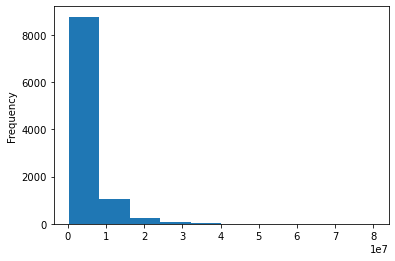

In [25]:
df['Monto'].plot.hist()

## Final schema of columns for cleaned data

In [26]:
# df.columns = normalize_columns_name(df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205 entries, 0 to 10204
Data columns (total 61 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Tipo                                 10205 non-null  category      
 1   Nro_Solicitud                        10205 non-null  int64         
 2   Obligacion                           10205 non-null  int64         
 3   Pagare                               10205 non-null  object        
 4   Homologacion Documento de Identidad  10205 non-null  object        
 5   Cod_tipoCliente                      10205 non-null  category      
 6   Nom_tipoCliente                      10205 non-null  category      
 7   Sucursal                             10205 non-null  category      
 8   Region_Cliente                       10205 non-null  category      
 9   Municipio_cliente                    10205 non-null  category      
 10  ubicacio_c

In [27]:
# os.makedirs(CLEAN_DATA_PATH, exist_ok=True)

# df.to_csv(f'{CLEAN_DATA_PATH}/{file_name}')

## Data exploration

The lack of information prev 2018 is due to missing of an information system or due to low operations?

In [28]:
date_value_counts = df['Fec_Desembolso'].value_counts(sort=False)

<AxesSubplot:xlabel='FEC_DESEMBOLSO', ylabel='NUMBER OF COLLOCATIONS'>

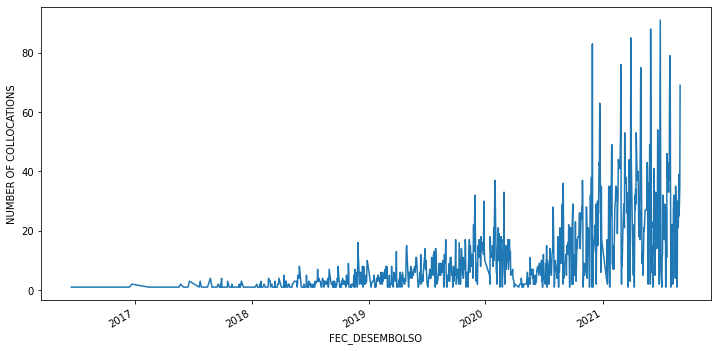

In [29]:
plt.figure(figsize=(12, 6)) 
date_value_counts.plot(ylabel="NUMBER OF COLLOCATIONS", xlabel='FEC_DESEMBOLSO')

In [30]:
date_value_counts[date_value_counts == 1]

2018-04-04    1
2020-06-28    1
2018-11-27    1
2018-01-12    1
2019-03-04    1
             ..
2017-02-14    1
2018-04-05    1
2018-07-10    1
2020-05-13    1
2017-09-04    1
Name: Fec_Desembolso, Length: 189, dtype: int64

In [31]:
amounts_per_date = df.groupby('Fec_Desembolso').sum('Monto')

amounts_per_date

,Nro_Solicitud,Obligacion,Edad,Monto,Valor_cuota,Cuotas_pactadas,Cuotas_pendientes,Tasa N.A.M.V,Tasa Periodica,Saldo_Obligacion,Dias_vencido,Capital_Ven,Interes_Ven,Mora,Seguro_Vida,COmision,Otros,Negocio,P_mypime,exist_Tel.Fijo,exist_Celular,exist_Correo,exist_Tel_Negocio
Fec_Desembolso,,,,,,,,,,,,,,,,,,,,,,,
2016-06-17,64361,64361,57,25000000,870974,54,14,33.60,2.80,9905390,463,9905390,2028242,497504,45000,0,0,5538.0,0.00000,1,1,1,1
2016-06-23,64576,64576,56,22500000,543000,19,9,31.20,2.60,4045407,0,0,-639,0,-3000,0,0,15329.0,0.00000,1,1,1,1
2016-06-27,64737,64737,57,30000000,491505,27,25,31.20,2.60,8898305,0,0,-2351,0,-3000,0,0,13218.0,0.00000,1,1,1,1
2016-06-29,64810,64810,42,34000000,923000,57,32,33.60,2.80,19241317,569,9393983,8078474,3314969,54000,0,0,13903.0,0.00000,1,1,1,1
2016-07-15,65266,65266,52,20000000,573000,15,5,33.60,2.80,2550361,0,0,-53495,0,-3000,0,0,7729.0,0.00000,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-26,20563013673,20263018364,1209,103000000,14002048,411,411,842.40,117.42,103000000,0,0,-715579,0,0,0,0,556007.0,1.93380,25,25,25,20
2021-08-27,23558022228,22598041809,1739,177112000,16906826,750,750,1358.28,161.36,177112000,0,0,-1243595,0,0,0,0,886914.0,7.88385,39,39,39,33
2021-08-28,22441016458,21601018685,1050,67312000,10810509,314,314,866.64,136.12,67312000,0,0,-411471,0,0,0,0,748586.0,4.90880,25,25,25,25


<AxesSubplot:xlabel='FEC_DESEMBOLSO', ylabel='AMOUNT OF COLLOCATIONS'>

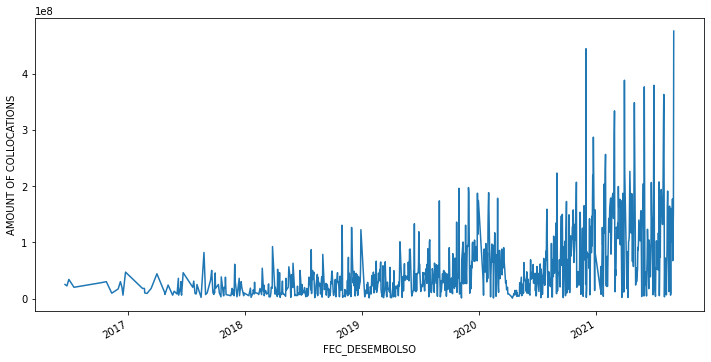

In [32]:
plt.figure(figsize=(12, 6))
amounts_per_date['Monto'].plot(ylabel="AMOUNT OF COLLOCATIONS", xlabel='FEC_DESEMBOLSO')

In [33]:
agg_per_date = df.groupby('Fec_Desembolso').aggregate({'Monto':['mean', 'sum'], 'Fec_Desembolso':'count'})

agg_per_date

Monto            Fec_Desembolso
                        mean        sum          count
Fec_Desembolso                                        
2016-06-17      2.500000e+07   25000000              1
2016-06-23      2.250000e+07   22500000              1
2016-06-27      3.000000e+07   30000000              1
2016-06-29      3.400000e+07   34000000              1
2016-07-15      2.000000e+07   20000000              1
...                      ...        ...            ...
2021-08-26      4.120000e+06  103000000             25
2021-08-27      4.541333e+06  177112000             39
2021-08-28      2.692480e+06   67312000             25
2021-08-30      4.520112e+06  158203923             35
2021-08-31      6.898537e+06  475999051             69

[946 rows x 3 columns]

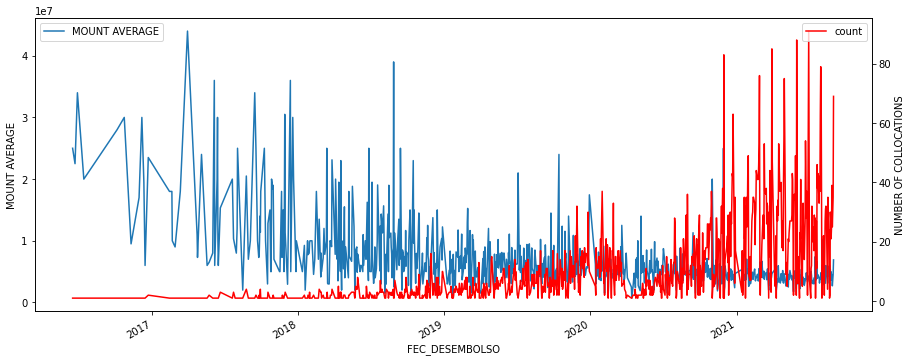

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
ax2 = ax.twinx()

ylabel = "MOUNT AVERAGE"
agg_per_date[('Monto', 'mean')].plot(ax=ax, label=ylabel, ylabel=ylabel, xlabel='FEC_DESEMBOLSO')

ylabel = "NUMBER OF COLLOCATIONS"
agg_per_date['Fec_Desembolso'].plot(ax=ax2, color='red', label=ylabel, ylabel=ylabel, xlabel='FEC_DESEMBOLSO')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

In [35]:
df

,Tipo,Nro_Solicitud,Obligacion,Pagare,Homologacion Documento de Identidad,Cod_tipoCliente,Nom_tipoCliente,Sucursal,Region_Cliente,Municipio_cliente,ubicacio_cliente,Fec_nacimiento,Edad,Mujer_Cabeza,Profesion,Genero,Estrato,Nivel_estudio,Est_Civil,Monto,Fec_solicitud,Fec_Aproba,Fec_Desembolso,Valor_cuota,Cuotas_pactadas,Cuotas_pendientes,Tasa N.A.M.V,Tasa Periodica,Periodicidad,Calificacion_Cierre,Cod_Linea,Linea,Cod_modalidad,Modalidad,Saldo_Obligacion,Dias_vencido,Capital_Ven,Interes_Ven,Mora,Seguro_Vida,COmision,Otros,Fec_ult.Pago,Fec_Proximo_Pago,Vencimiento Final,Codeudores,Garntia_real,Porcentaje_pago,Tipo Credito,Fecha_utl_actualizacion,Direccion,Negocio,Dir_Negocio,Barrio_Negocio,K_Zona_Neg,N_zona_Neg,P_mypime,exist_Tel.Fijo,exist_Celular,exist_Correo,exist_Tel_Negocio
0,10,1914000157,1914000083,1914000083,FA1,1,Microfinanciero,TUNJA,CENTRO BOYACA,SORACA,RURAL,1955-03-30,67,N,DESCONOCIDA,Masculino,1.0,Primaria,Casado,4000000,2019-11-29,30/11/2019,2019-11-30,709721,8,2,31.68,8.13,Trimestral,A,GER,GERMINA,403,CREDITO RURAL INDIVIDUAL GERMINA,1245198,0,0,-473,0,0,0,0,2021-12-20,2021-09-04,2021-12-04,SIN CODEUDORES,SIN GARANTIAS REALES,31.13,NUEVO,NaT,VD QUEBRADA VIEJA FINCA BUENOS AIRES,34447.0,FINCA BUENOS AIRES,QUEBRADA VIEJA,8-010,RCB-TUNJA,0.00000,True,True,True,True
1,10,2014000448,1914000230,1914000230,FA10,1,Microfinanciero,TUNJA,CENTRO BOYACA,SIACHOQUE,RURAL,1966-06-11,55,N,DESCONOCIDA,Masculino,1.0,Primaria,Casado,3000000,2020-03-20,25/03/2020,2020-03-25,542390,8,5,33.60,8.64,Trimestral,E,GER,GERMINA,412,CREDITO RURAL INDIVIDUAL - GERMINA NUEVO,2099670,148,737291,326864,99029,15314,0,0,2021-02-25,2021-04-02,2022-04-02,SIN CODEUDORES,SIN GARANTIAS REALES,69.99,NUEVO,NaT,VD CORMECHOQUE ARRIBA SIACHOQUE,35838.0,VEREDA CORMECHOQUE ARRIBA,VEREDA CORMECHOQUE ARRIBA,8-010,RCB-TUNJA,0.00000,False,True,True,True
2,10,202005053,192003792,192003792,FA10001,1,Microfinanciero,VILLAVICENCIO,REGION VILLAVICENCIO,VILLAVICENCIO,URBANA,1983-12-24,38,N,DESCONOCIDA,Femenino,1.0,Secundaria,Soltero,6000000,2020-10-15,16/10/2020,2020-10-16,357099,24,14,35.28,2.94,Mensual,A,MCA,MI CASA,404,MICROVIVIENDA,3992507,0,0,0,0,-51,0,0,2021-12-29,2021-09-16,2022-10-16,SIN CODEUDORES,SIN GARANTIAS REALES,66.54,RENOVADO,2016-12-31,CL 44 A No 17 - 78,25734.0,CALLER 44 A 17 78 VILLA SUARESZ SEC EXITO VECINO,VILLA SUAREZ,6-010,RV-VILLAVICENCIO,0.00000,True,True,True,True
3,10,212000256,192004245,192004245,FA10002,1,Microfinanciero,VILLAVICENCIO,REGION VILLAVICENCIO,VILLAVICENCIO,URBANA,1976-06-05,45,N,ADMON DE NEGOCIOS,Femenino,2.0,Secundaria,Union libre,4500000,2021-03-12,15/03/2021,2021-03-15,267824,24,19,35.28,2.94,Mensual,A,MCA,MI CASA,404,MICROVIVIENDA,3801630,0,0,-8852,0,-3825,0,0,2022-03-15,2021-09-15,2023-03-15,"86054735 BUENAVENTURA DUCUARA DIEGO JAUID,",SIN GARANTIAS REALES,84.48,RENOVADO,2016-12-31,CR 9 B No 26 A 105,11607.0,CR 9B No 26A - 105,EL RECREO,6-010,RV-VILLAVICENCIO,0.00000,False,True,True,True
4,10,212000222,192004212,192004212,FA10003,1,Microfinanciero,VILLAVICENCIO,REGION VILLAVICENCIO,VILLAVICENCIO,URBANA,1964-02-11,58,N,DESCONOCIDA,Femenino,2.0,Secundaria,Viudo,4500000,2021-03-04,5/03/2021,2021-03-05,280715,24,19,35.28,2.94,Mensual,A,CRE,CRECER,400,DESARROLLO EMPRESARIAL CRECER (PYME) RENOVACION,3833842,0,0,-95635,0,0,0,0,2022-03-07,2021-09-05,2023-03-05,SIN CODEUDORES,SIN GARANTIAS REALES,85.2,RENOVADO,2016-12-31,CL 41 No 19 B - 62,12034.0,CALLE 41 NRO 19B 62 PARAISO,PARAISO,6-010,RV-VILLAVICENCIO,0.44625,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10200,10,198004501,198004396,198004396,FA999,1,Microfinanciero,PAZ DE ARIPORO,REGION NORTE,HATO COROZAL,URBANA,1991-08-17,30,N,ACUICULTURA,Femenino,2.0,Secundaria,Union libre,3000000,2019-10-01,8/10/2019,2019-10-08,152550,23,8,35.28,2.94,Mensual,B,CRE,CRECER,40